# Libs

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import pandas as pd 
import numpy as np 

# Load data

In [4]:
path_application_train = '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/application_train.csv/application_train.csv'
application_train = pd.read_csv(path_application_train)

In [5]:
temp, test = train_test_split(application_train, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209107, 122), (52277, 122), (46127, 122))

# Feature selection

In [6]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
#     for ivars in ['AMT_REQ_CREDIT_BUREAU_YEAR']:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        
        # missing
        if d0.isnull().sum().sum() > 0 :
            try:
                d0['x'] = d0['x'].cat.add_categories('Missing')
                d0['x'].fillna('Missing', inplace =True)
            except:
#                 print('var ', ivars)
                d0['x'].fillna('Missing', inplace =True)

            
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
#         print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [7]:
newDF, woeDF = iv_woe(data = train.drop(columns = ['SK_ID_CURR']),
                        target = 'TARGET')

In [8]:
newDF[newDF['IV']>= 0.02]

,Variable,IV
0,CODE_GENDER,0.040247
0,AMT_CREDIT,0.041850
0,AMT_ANNUITY,0.027567
0,AMT_GOODS_PRICE,0.090133
0,NAME_INCOME_TYPE,0.055189
0,NAME_EDUCATION_TYPE,0.054507
0,NAME_FAMILY_STATUS,0.022683
0,REGION_POPULATION_RELATIVE,0.033982
0,DAYS_BIRTH,0.081339
0,DAYS_EMPLOYED,0.100419


In [9]:
# chon bien co IV >= 0.02
woeDF[woeDF['Variable'].isin(newDF[newDF['IV']>= 0.02]['Variable'])]

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,F,137654,9591,0.568861,128063,0.666138,-0.157860,0.015356
1,CODE_GENDER,M,71450,7269,0.431139,64181,0.333847,0.255749,0.024882
2,CODE_GENDER,XNA,3,0,0.000030,3,0.000016,0.642078,0.000009
0,AMT_CREDIT,"(44999.999, 180000.0]",22634,1535,0.091044,21099,0.109749,-0.186858,0.003495
1,AMT_CREDIT,"(180000.0, 254700.0]",21644,1715,0.101720,19929,0.103664,-0.018926,0.000037
...,...,...,...,...,...,...,...,...,...
7,DAYS_LAST_PHONE_CHANGE,"(-363.0, -161.0]",20847,2061,0.122242,18786,0.097718,0.223916,0.005491
8,DAYS_LAST_PHONE_CHANGE,"(-161.0, 0.0]",41820,3950,0.234282,37870,0.196986,0.173393,0.006467
9,DAYS_LAST_PHONE_CHANGE,Missing,1,0,0.000030,1,0.000005,1.740690,0.000043
0,FLAG_DOCUMENT_3,0,60687,3775,0.223903,56912,0.296036,-0.279269,0.020145


In [10]:
transform_woe_df = woeDF[woeDF['Variable'].isin(newDF[newDF['IV']>= 0.02]['Variable'])]
transform_woe_df.shape

(488, 9)

In [11]:
final_list = list(transform_woe_df['Variable'].unique())
print(len(final_list))
keep_cols = final_list + ['TARGET']
print(len(keep_cols), keep_cols)

53
54 ['CODE_GENDER', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSM

# WOE transformation

In [12]:
map_transform_dict = {}
for idx in range(transform_woe_df.shape[0]):
    var = transform_woe_df.iloc[idx]['Variable']
    cutoff = transform_woe_df.iloc[idx]['Cutoff']
    woe = float(transform_woe_df.iloc[idx]['WoE'])
    
    if var not in map_transform_dict:
        map_transform_dict[var] = [[], []]  ## cutoff, woe
    if str(cutoff) == 'Missing':
        map_transform_dict[var][0].append('Missing')
    elif '(' not in str(cutoff):
        map_transform_dict[var][0].append(cutoff)
    elif '(' in str(cutoff):
        cutoff_str = str(cutoff).replace('(', '').replace(']', '')
        upper = cutoff_str.split(',')[0]
        lower = cutoff_str.split(',')[-1]
        map_transform_dict[var][0].append([upper, lower])
    map_transform_dict[var][1].append(woe)

In [13]:
from tqdm import tqdm
def map_woe_values(data, map_transform_dict):
    data = data.reset_index().drop(columns = ['index'])
    data_copy = copy.deepcopy(data)
    
    for var in tqdm(map_transform_dict.keys()):
#     for var in ['CODE_GENDER']:
        cutoff_lst, woe_lst = map_transform_dict[var]
        for idx in range(len(cutoff_lst)):
            cutoff = cutoff_lst[idx]
            woe = woe_lst[idx]
            if type(cutoff) == int:
                data[var] = data[var].replace({cutoff: woe})
                
            elif type(cutoff) == str:
                if str(cutoff) != 'Missing':
                    data[var] = data[var].replace({cutoff: woe})
                elif str(cutoff) == 'Missing':
                    data[var] = data[var].fillna(woe)
                
            elif len(cutoff) == 1:
                if str(cutoff) != 'Missing':
                    print('pass len cutoff == 1 , value != Missing')
                    data[var] = data[var].map({cutoff: woe})
                    
            elif len(cutoff) == 2:
                upper = float(cutoff[0])
                lower = float(cutoff[-1])
                index_ = data_copy[(data_copy[var]> upper)&
                                   (data_copy[var]<= lower)].index
                data.iloc[index_, data.columns.get_loc(var)] = woe
                
    return data, data_copy

In [14]:
train_w = train[keep_cols].reset_index().drop(columns = ['index'])
train_temp = copy.deepcopy(train_w)
train_map, train_copy = map_woe_values(data = train_temp, map_transform_dict = map_transform_dict)
train_map.head()

100%|██████████| 53/53 [00:08<00:00,  6.17it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLOORSMAX_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,TARGET
0,-0.157860,-0.436911,0.081624,-0.214634,-0.072190,-0.457985,-0.074781,0.081374,0.004109,0.024317,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,0.173393,0.09755,0
1,-0.157860,-0.179499,0.254026,-0.214634,0.182382,0.116950,-0.074781,0.204672,0.215778,0.274353,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,-0.435658,0.09755,0
2,0.255749,0.038009,0.024883,0.244880,0.182382,0.116950,0.201531,-0.093574,0.215778,0.372352,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,0.223916,0.09755,0
3,-0.157860,0.225065,0.024883,-0.043278,-0.072190,0.116950,-0.074781,0.081374,0.325326,0.024317,...,0.002822,-0.103219,-0.124194,-0.167535,-0.172303,0.211481,-0.166999,-0.126586,0.09755,0
4,-0.157860,0.038009,0.024883,0.113389,-0.418138,0.116950,0.035454,-0.027408,-0.528614,-0.317732,...,-0.417369,-0.205117,-0.401862,-0.167535,-0.243325,-0.260458,-0.166999,-0.435658,0.09755,0


In [15]:
train_map.isnull().sum().sum()


0

In [16]:
valid_w = valid[keep_cols].reset_index().drop(columns = ['index'])
valid_temp = copy.deepcopy(valid_w)
valid_map, valid_copy = map_woe_values(data = valid_temp, map_transform_dict = map_transform_dict)
valid_map.head()

100%|██████████| 53/53 [00:02<00:00, 20.47it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLOORSMAX_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,TARGET
0,-0.157860,0.198455,0.061495,0.244880,0.182382,0.301717,-0.074781,0.081374,0.082488,-0.133433,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,-0.435658,-0.279269,0
1,-0.157860,-0.018926,0.061495,0.113389,-0.418138,0.116950,0.254015,0.157036,-0.528614,-0.317732,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,0.159968,0.097550,0
2,-0.157860,-0.018926,-0.145876,0.113389,-0.418138,0.116950,-0.352007,0.157036,-0.528614,-0.317732,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,0.159968,-0.279269,0
3,0.255749,0.271252,0.074683,-0.212795,0.182382,0.116950,-0.074781,-0.093574,0.325326,0.372352,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,0.173393,-0.279269,0
4,-0.157860,-0.179499,-0.383264,-0.214634,0.182382,-0.457985,-0.074781,-0.005537,0.004109,0.274353,...,-0.508621,-0.451785,-0.209040,-0.167535,-0.449737,-0.260458,-0.166999,-0.233760,-0.279269,0


In [17]:
test_w = test[keep_cols].reset_index().drop(columns = ['index'])
test_temp = copy.deepcopy(test_w)
test_map, test_copy = map_woe_values(data = test_temp, map_transform_dict = map_transform_dict)
test_map.head()

100%|██████████| 53/53 [00:02<00:00, 22.12it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLOORSMAX_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,TARGET
0,-0.157860,0.225065,0.074683,0.545279,0.182382,0.116950,-0.074781,-0.027408,0.004109,-0.316021,...,-0.143167,0.052102,-0.165199,-0.167535,-0.185737,-0.110936,-0.166999,-0.126586,-0.279269,0
1,0.255749,0.225065,0.024883,0.244880,-0.072190,0.116950,-0.074781,-0.093574,-0.132915,0.372352,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,0.223916,-0.279269,0
2,0.255749,-0.179499,-0.070479,-0.214634,-0.072190,-0.457985,-0.074781,0.081374,0.082488,0.202327,...,0.002822,0.052102,-0.141363,-0.167535,0.096168,-0.110936,-0.166999,0.159968,-0.279269,0
3,-0.157860,0.029031,0.024883,0.545279,-0.072190,0.116950,0.201531,0.147449,-0.132915,0.369761,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,0.173393,0.097550,0
4,-0.157860,-0.186858,-0.145876,-0.094729,0.182382,0.039970,-0.074781,-0.005537,0.215778,0.202327,...,0.146621,0.140594,0.125241,0.142458,0.152408,0.138764,0.155455,-0.299370,-0.279269,0


# Logit

In [18]:
log_reg_w = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg_w.fit(train_map.drop(['TARGET'],axis=1), train_map['TARGET'])

LogisticRegression(C=0.0001)

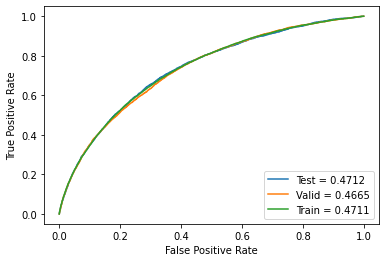

In [19]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = log_reg_w.predict_proba(test_map.drop(['TARGET'],axis=1))[:, 1]
pred_valid = log_reg_w.predict_proba(valid_map.drop(['TARGET'],axis=1))[:, 1]
pred_train = log_reg_w.predict_proba(train_map.drop(['TARGET'],axis=1))[:, 1]

plot_roc_curve(true_y = (test_map['TARGET'], valid_map['TARGET'], train_map['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

# LGBM

In [20]:
lgb_train_w = lgb.Dataset(data=train_map.drop(['TARGET'],axis=1),
                        label=train_map.TARGET)
lgb_valid_w = lgb.Dataset(data=valid_map.drop(['TARGET'],axis=1),
                       label=valid_map.TARGET)
lgb_test_w = lgb.Dataset(data=test_map.drop(['TARGET'],axis=1),
                      label= test_map.TARGET)

In [21]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 20,
          'max_bin': 20,
          'num_iteration': 1000,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}
model_lgb_w = lgb.train(params, lgb_train_w, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train_w, lgb_valid_w], early_stopping_rounds=50)

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 16860, number of negative: 192247
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080629 -> initscore=-2.433837
[LightGBM] [Info] Start training from score -2.433837
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.730492	valid_1's auc: 0.722749
[100]	training's auc: 0.737624	valid_1's auc: 0.730321
[150]	training's auc: 0.742515	valid_1's auc: 0.735002
[200]	training's auc: 0.746963	valid_1's auc: 0.739269
[250]	training's auc: 0.750481	valid_1's auc: 0.742022
[300]	training's auc: 0.753271	valid_1's auc: 0.74405
[350]	training's auc: 0.755624	valid_1's auc: 0.7

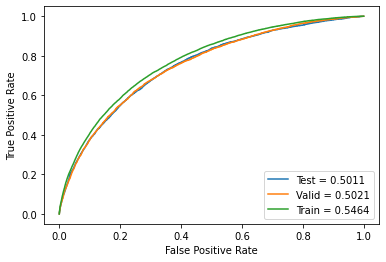

In [22]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = model_lgb_w.predict(test_map.drop(['TARGET'],axis=1))
pred_valid = model_lgb_w.predict(valid_map.drop(['TARGET'],axis=1))
pred_train = model_lgb_w.predict(train_map.drop(['TARGET'],axis=1))

plot_roc_curve(true_y = (test_map['TARGET'], valid_map['TARGET'], train_map['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))